In [1]:
import supereeg as se
import numpy as np
from scipy.spatial.distance import cdist
from scipy.special import logsumexp
import seaborn as sns
%matplotlib inline
from joblib import Parallel, delayed
import multiprocessing
import copy

In [2]:
#you should call these functions directly from the supereeg toolbox rather than re-defining them

def z2r(z):

    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

def r2z(r):

    return 0.5 * (np.log(1 + r) - np.log(1 - r))

def _to_log_complex(X):

    signX = np.sign(X)
    posX = np.log(np.multiply(signX > 0, X))
    negX = np.log(np.abs(np.multiply(signX < 0, X)))

    negX = np.multiply(0+1j, negX)
    negX.real[np.isnan(negX)] = 0

    return posX + negX

def _to_exp_real(C):

    posX = C.real
    negX = C.imag
    return np.exp(posX) - np.exp(negX)

def _set_numerator(n_real, n_imag):

    numerator = np.zeros_like(n_real, dtype=np.complex128)
    numerator.real = n_real
    numerator.imag = n_imag

def _recover_model(num, denom, z_transform=False):

    m = np.divide(_to_exp_real(num), np.exp(denom)) #numerator and denominator are in log units
    if z_transform:
        np.fill_diagonal(m, np.inf)
        return m
    else:
        np.fill_diagonal(m, 1)
        return z2r(m)


### example with real numbers

In [3]:
a = np.array([[1,2,3],[4,5,6],[7,8,9,]])
b = np.array([[-1,2,2],[-4,5,5],[-7,8,8,]])
c = np.array([[ 0,  4, 5], [ 0, 10, 11],[ 0, 16, 17]])

## check a + b == c

In [4]:
np.allclose(a+b, c, equal_nan=True)

True

In [5]:
#make this a function-- given three matrices (a, b, and c), return True if a + b == c and False otherwise

add_log = _to_log_complex(a)

a_log = _to_log_complex(a)
b_log = _to_log_complex(b)
c_log = _to_log_complex(c)

add_log.real = np.logaddexp(a_log.real,b_log.real)
add_log.imag = np.logaddexp(a_log.imag,b_log.imag)

try_add = _to_exp_real(add_log)

np.allclose(try_add, c, equal_nan=True)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


True

## check c - a = b

In [6]:
#can test this using the addition checker function-- pass in c, -a, and b as the three arguments

sub_log = _to_log_complex(a)

## multiply a by -1 
neg_a_log = _to_log_complex(-a)

sub_log.real = np.logaddexp(c_log.real, neg_a_log.real)
sub_log.imag = np.logaddexp(c_log.imag, neg_a_log.imag)

b_try = _to_exp_real(sub_log)
np.allclose(b_try, b)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


True

## make it into a function

In [7]:
#this can be used for the __sub__ function in Model objects
def _logsubexp(x,y):
    """
    Subtracts logged arrays
    Parameters
    ----------
    x : Numpy array
        Log complex array
    y : Numpy array
        Log complex array
    Returns
    ----------
    z : Numpy array
        Returns log complex array of x-y
    """
    if np.any(np.iscomplex(y)): 
        y = _to_exp_real(y)
    else:
        y = np.exp(y)
    sub_log = _to_log_complex(x)
    neg_y_log = _to_log_complex(-y)
    sub_log.real = np.logaddexp(x.real, neg_y_log.real)
    sub_log.imag = np.logaddexp(x.imag, neg_y_log.imag)
    return sub_log

In [8]:
try_it = _to_exp_real(_logsubexp(c_log,a_log))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


In [9]:
try_it

array([[-1.,  2.,  2.],
       [-4.,  5.,  5.],
       [-7.,  8.,  8.]])

In [10]:
np.allclose(try_it,b)

True

## if infs as values 

In [11]:
d = np.array([[1,2,-np.inf],[4,5,6],[7,8,9,]])
e = np.array([[2,2,2],[5,5,5],[7,8,8,]])
f = np.array([[3,4,np.inf], [9,10,11],[14,16,17]])

In [12]:
_to_exp_real(_to_log_complex(d))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply


array([[ 1.,  2., nan],
       [ 4.,  5.,  6.],
       [ 7.,  8.,  9.]])

In [13]:
add_log = _to_log_complex(d)

d_log = _to_log_complex(d)
e_log = _to_log_complex(e)
f_log = _to_log_complex(f)

add_log.real = np.logaddexp(d_log.real,e_log.real)
add_log.imag = np.logaddexp(d_log.imag,e_log.imag)

try_add =_to_exp_real(add_log)

np.allclose(try_add, f)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in multiply


False

In [14]:
np.any(np.iscomplex(d_log))

True

### are to_log_complex and to_exp_real inverses of each other?

In [15]:
d_log_inverse = _to_log_complex(_to_exp_real(d_log))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply


In [16]:
np.allclose(d_log_inverse, d_log) ### that shoulds be the same i think

/Library/Python/2.7/site-packages/numpy/core/numeric.py:2342: RuntimeWarning: invalid value encountered in multiply
  x = x * ones_like(cond)
/Library/Python/2.7/site-packages/numpy/core/numeric.py:2343: RuntimeWarning: invalid value encountered in multiply
  y = y * ones_like(cond)


False

In [17]:
d

array([[  1.,   2., -inf],
       [  4.,   5.,   6.],
       [  7.,   8.,   9.]])

In [18]:
np.log(np.inf)

inf

In [19]:
d_log_inverse

array([[0.        -infj, 0.69314718-infj,        nan+nanj],
       [1.38629436-infj, 1.60943791-infj, 1.79175947-infj],
       [1.94591015-infj, 2.07944154-infj, 2.19722458-infj]])

In [20]:
d_log

array([[0.        -infj, 0.69314718-infj,        nan+infj],
       [1.38629436-infj, 1.60943791-infj, 1.79175947-infj],
       [1.94591015-infj, 2.07944154-infj, 2.19722458-infj]])

### what about exp and log inverses with infs? YAS!

In [21]:
np.exp(np.log(d))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


array([[ 1.,  2., nan],
       [ 4.,  5.,  6.],
       [ 7.,  8.,  9.]])

### looks like it's in there inverse everywhere excepts when there are infs

## If nans:

In [22]:
try_nan = np.array([[1,2,np.nan],[4,5,6],[7,8,9,]])
try_nan_log = _to_log_complex(try_nan)
nan_inverse = _to_log_complex(_to_exp_real(try_nan_log))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply


In [23]:
np.allclose(nan_inverse, try_nan_log, equal_nan=True)

True

### Nans are fine... really just when infs are made into complex numbers

In [24]:
try_complex = _to_exp_real(_logsubexp(f_log,d_log))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater
/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less


In [25]:
np.allclose(try_complex,e)

False

# Now try to update the functions in model.py

### The expand_corrmat_predict function calculates only the expanded locations by looping over the upper triangle of the remaining locations and storing the indices as 'sliced_up'.  This then allows us to parrallelize the compute_coord function for each set of index values.  The compute_coord function is essentially the inner loop of the original nested for loop function (calculating the sum of the weights and the sum of the weighted correlation values).  

In [26]:
def fill_upper_diagonal(M, value):
    upper_tri = np.copy(M)
    upper_tri[np.triu_indices(upper_tri.shape[0], 1)] = value
    np.fill_diagonal(upper_tri, value)
    return upper_tri

In [27]:

def _compute_coord_exp(coord, weights, Z):
    next_weights = np.add.outer(weights[coord[0], :], weights[coord[1], :])

    W = fill_upper_diagonal(next_weights, -np.inf)
    
    return np.exp(logsumexp(W)), np.exp(logsumexp(W, b=Z))


#could call the supereeg toolbox version of this function directly
def _compute_coord_old(coord, weights, Z):
    exp_weights = np.exp(weights)
    next_weights = np.outer(exp_weights[coord[0], :], exp_weights[coord[1], :])
    next_weights = next_weights - np.triu(next_weights) 
    return np.sum(next_weights), np.sum(Z * next_weights)


#could call the supereeg toolbox version of this function directly
def _log_rbf(to_coords, from_coords, width=20):

    assert np.isscalar(width), 'RBF width must be a scalar'
    assert width > 0, 'RBF width must be positive'
    weights = -cdist(to_coords, from_coords, metric='euclidean') ** 2 / float(width)
    return weights

## Define some sample locations, and subsample

In [28]:
#make a brain object?
locs = np.array([[-61., -77.,  -3.],
                 [-41., -77., -23.],
                 [-21., -97.,  17.],
                 [-21., -37.,  77.],
                 [-21.,  63.,  -3.],
                 [ -1., -37.,  37.],
                 [ -1.,  23.,  17.],
                 [ 19., -57., -23.],
                 [ 19.,  23.,  -3.],
                 [ 39., -57.,  17.],
                 [ 39.,   3.,  37.],
                 [ 59., -17.,  17.]])

sub_locs = locs[6:]

## Get log weights from these locations

In [29]:
weights = _log_rbf(sub_locs, locs, width=20)

## Make up a full correlation matrix 

In [30]:
Z = r2z(se.create_cov(cov='random', n_elecs=np.shape(locs)[0]))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log


In [31]:
Z[np.where(np.isinf(Z))] = 0

## Define an example coord

In [32]:
#it looks like this is working(!!!)--
#but try this with a full matrix (i.e. the full expand_corrmat) and use np.allclose 
#to verify that the answers are the close everywhere

coord = tuple((3, 0))



try_old = _compute_coord_old(coord, weights, Z)
try_new = _compute_coord_exp(coord, weights, Z)

# They're the same!!!!!!

In [33]:
try_old

(1.0, 0.018564063780372307)

In [34]:
try_new

(1.0, 0.01856406378037231)

## Comparing line by line

### 1: adding vs multiplying outer products

In [35]:
next_weights_log = np.add.outer(weights[coord[0], :], weights[coord[1], :])

In [36]:
next_weights_log

array([[-1240., -1200., -1280.,  -920.,  -660.,  -740.,  -540.,  -960.,
         -580.,  -940.,  -660.,  -800.],
       [-1120., -1080., -1160.,  -800.,  -540.,  -620.,  -420.,  -840.,
         -460.,  -820.,  -540.,  -680.],
       [ -960.,  -920., -1000.,  -640.,  -380.,  -460.,  -260.,  -680.,
         -300.,  -660.,  -380.,  -520.],
       [-1080., -1040., -1120.,  -760.,  -500.,  -580.,  -380.,  -800.,
         -420.,  -780.,  -500.,  -640.],
       [-1620., -1580., -1660., -1300., -1040., -1120.,  -920., -1340.,
         -960., -1320., -1040., -1180.],
       [ -820.,  -780.,  -860.,  -500.,  -240.,  -320.,  -120.,  -540.,
         -160.,  -520.,  -240.,  -380.],
       [-1100., -1060., -1140.,  -780.,  -520.,  -600.,  -400.,  -820.,
         -440.,  -800.,  -520.,  -660.],
       [ -800.,  -760.,  -840.,  -480.,  -220.,  -300.,  -100.,  -520.,
         -140.,  -500.,  -220.,  -360.],
       [-1060., -1020., -1100.,  -740.,  -480.,  -560.,  -360.,  -780.,
         -400.,  -760., 

In [37]:
try_1_new = np.exp(next_weights_log)

In [38]:
exp_weights = np.exp(weights)

In [39]:
try_1_old = np.outer(exp_weights[coord[0], :], exp_weights[coord[1], :])

### Adding outer product with logs same as taking outer product with the exponentiated weights

In [40]:
np.allclose(try_1_old, try_1_new)

True

### 2: replace upper triangle and diagonal of weights with -infs

In [41]:
try_1_old[10]

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.28588016e-252,
       1.06112315e-139, 1.91516960e-174, 1.38389653e-087, 5.46287446e-270,
       5.87928270e-105, 2.65039655e-261, 1.06112315e-139, 1.67702032e-200])

In [42]:
np.triu(try_1_old)[10]

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 1.06112315e-139, 1.67702032e-200])

In [43]:
subtract_exp = try_1_old - np.triu(try_1_old)

In [44]:
subtract_exp[10]

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.28588016e-252,
       1.06112315e-139, 1.91516960e-174, 1.38389653e-087, 5.46287446e-270,
       5.87928270e-105, 2.65039655e-261, 0.00000000e+000, 0.00000000e+000])

In [45]:
W = fill_upper_diagonal(next_weights_log, -np.inf)
W

array([[  -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf],
       [-1120.,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf],
       [ -960.,  -920.,   -inf,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf],
       [-1080., -1040., -1120.,   -inf,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf],
       [-1620., -1580., -1660., -1300.,   -inf,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf],
       [ -820.,  -780.,  -860.,  -500.,  -240.,   -inf,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf],
       [-1100., -1060., -1140.,  -780.,  -520.,  -600.,   -inf,   -inf,
          -inf,   -inf,   -inf,   -inf],
       [ -800.,  -760.,  -840.,  -480.,  -220.,  -300.,  -100.,   -inf,
          -inf,   -inf,   -inf,   -inf],
       [-1060., -1020., -1100.,  -740.,  -480.,  -560.,  -360.,  -780.,
          -inf,   -inf, 

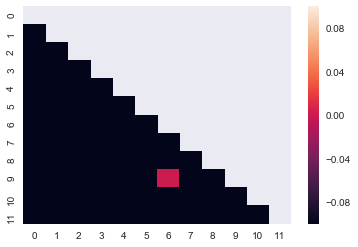

In [46]:
sns.heatmap(W)

In [47]:
next_weights_log[10]

array([-900., -860., -940., -580., -320., -400., -200., -620., -240.,
       -600., -320., -460.])

In [48]:
W[10]

array([-900., -860., -940., -580., -320., -400., -200., -620., -240.,
       -600.,  -inf,  -inf])

###  -infs are filled in the same places

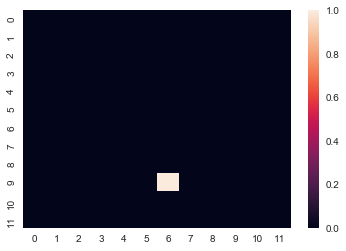

In [49]:
sns.heatmap(subtract_exp)

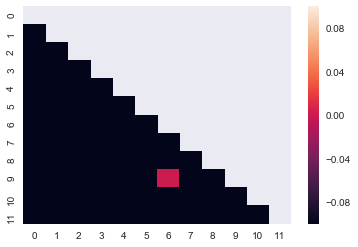

In [50]:
sns.heatmap(W)

### 3: summing the weights

### the old way sums to 1

In [51]:
np.sum(subtract_exp)

1.0

### and now with logsumexp!

In [52]:
np.exp(logsumexp(W))

1.0

### but shouldnt this also work????

In [53]:
#logsumexp(W) is not a complex number-- so I think _to_exp_real probably isn't working like you're expecting
#for example, the complex parts might be defaulting to -infs, which means when you exponentiate you get zeros.
#remember that _to_exp_real takes the real part and subtracts the complex part-- so -infs in the complex parts
#will make those differences go to -inf.
_to_exp_real(logsumexp(W))

0.0

### comparing the subtracted log vs exp values: they arent the same values but they have the same heatmap

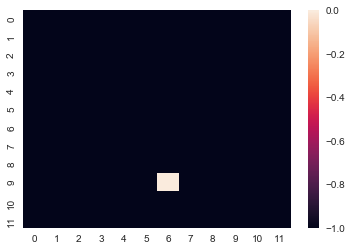

In [54]:
sns.heatmap(_to_exp_real(W))


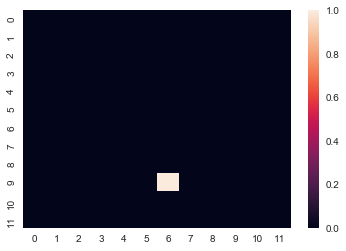

In [55]:
sns.heatmap(subtract_exp)

### Ok this looks right now

In [56]:
np.exp(logsumexp(W))

1.0

### try without logging Z

In [57]:
try_b = logsumexp(W, b=Z)

In [58]:
np.exp(try_b)  

0.01856406378037231

### thats it!!!

## as opposed to logging z:

array([[      -inf,       -inf,       -inf,       -inf,       -inf,
              -inf,       -inf,       -inf,       -inf,       -inf,
              -inf,       -inf],
       [0.46102477,       -inf,       -inf,       -inf,       -inf,
              -inf,       -inf,       -inf,       -inf,       -inf,
              -inf,       -inf],
       [0.43477523, 0.54888643,       -inf,       -inf,       -inf,
              -inf,       -inf,       -inf,       -inf,       -inf,
              -inf,       -inf],
       [0.38903979, 0.60923245, 0.67931198,       -inf,       -inf,
              -inf,       -inf,       -inf,       -inf,       -inf,
              -inf,       -inf],
       [0.51316005, 0.40475839, 0.32940364, 0.23253261,       -inf,
              -inf,       -inf,       -inf,       -inf,       -inf,
              -inf,       -inf],
       [0.46820843, 0.3536999 , 0.36049507, 0.13383065, 0.62792438,
              -inf,       -inf,       -inf,       -inf,       -inf,
              -inf,

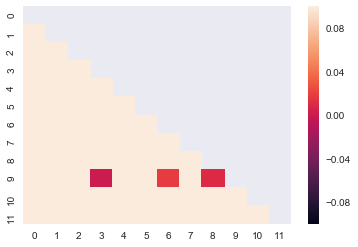

In [59]:
Z = fill_upper_diagonal(Z, -np.inf)

sns.heatmap(Z)
Z

In [60]:
try_b = logsumexp(W, b=Z)

/Library/Python/2.7/site-packages/scipy/special/_logsumexp.py:108: RuntimeWarning: invalid value encountered in multiply
  tmp = b * np.exp(a - a_max)


In [61]:
try_b

nan

In [62]:
log_z = _to_log_complex(Z)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in multiply
/Library/Python/2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply


In [63]:
log_z

array([[            nan+infj,             nan+infj,             nan+infj,
                    nan+infj,             nan+infj,             nan+infj,
                    nan+infj,             nan+infj,             nan+infj,
                    nan+infj,             nan+infj,             nan+infj],
       [-7.74303514e-01-infj,             nan+infj,             nan+infj,
                    nan+infj,             nan+infj,             nan+infj,
                    nan+infj,             nan+infj,             nan+infj,
                    nan+infj,             nan+infj,             nan+infj],
       [-8.32926095e-01-infj, -5.99863733e-01-infj,             nan+infj,
                    nan+infj,             nan+infj,             nan+infj,
                    nan+infj,             nan+infj,             nan+infj,
                    nan+infj,             nan+infj,             nan+infj],
       [-9.44073650e-01-infj, -4.95555397e-01-infj, -3.86674792e-01-infj,
                    nan+infj,      

In [64]:
def _fill_upper_diagonal(M, value):
    upper_tri = np.copy(M)
    upper_tri[np.triu_indices(upper_tri.shape[0], 1)] = value
    np.fill_diagonal(upper_tri, value)
    return upper_tri

In [65]:
def _compute_coord(coord, weights, Z):
    next_weights = np.add.outer(weights[coord[0], :], weights[coord[1], :])

    W = _fill_upper_diagonal(next_weights, -np.inf)

    return logsumexp(W), logsumexp(W, b=Z)


def _expand_corrmat_predict_parallel(Z, weights):
    """
    Gets full correlation matrix
    Parameters
    ----------
    C : Numpy array
        Subject's correlation matrix
    weights : Numpy array
        Weights matrix calculated using _rbf function matrix
    mode : str
        Specifies whether to compute over all elecs (fit mode) or just new elecs
        (predict mode)
    Returns
    ----------
    numerator : Numpy array
        Numerator for the expanded correlation matrix
    denominator : Numpy array
        Denominator for the expanded correlation matrix
    """


    Z[np.eye(Z.shape[0]) == 1] = 0
    Z[np.where(np.isinf(Z))] = 0
    #Z[np.where(np.isnan(Z))] = 0


    n = weights.shape[0]
    K = np.zeros([n, n])
    W = np.zeros([n, n])

    #s = Z.shape[0]

    s = 0

    sliced_up = [(x, y) for x in range(s, n) for y in range(x)]
    results = Parallel(n_jobs=multiprocessing.cpu_count())(
        delayed(_compute_coord)(coord, weights, Z) for coord in sliced_up)

    W[[x[0] for x in sliced_up], [x[1] for x in sliced_up]] = [x[0] for x in results]
    K[[x[0] for x in sliced_up], [x[1] for x in sliced_up]] = [x[1] for x in results]

    a = (K + K.T)
    b = (W + W.T)

    # a[np.where(a == 0)] = -np.inf
    # b[np.where(b == 0)] = -np.inf
    # np.fill_diagonal(a, 0)
    # np.fill_diagonal(b, 0)
    return a,b

In [66]:

def _expand_corrmat_predict_vect(Z, weights):
    """
    Gets expanded correlation matrix

    Parameters
    ----------
    C : Numpy array
        Subject's correlation matrix

    weights : Numpy array
        Weights matrix calculated using rbf function matrix

    mode : str
        Specifies whether to compute over all elecs (fit mode) or just new elecs
        (predict mode)

    Returns
    ----------
    numerator : Numpy array
        Numerator for the expanded correlation matrix
    denominator : Numpy array
        Denominator for the expanded correlation matrix

    """
    Z[np.eye(Z.shape[0]) == 1] = 0
    Z[np.where(np.isinf(Z))] = 0

    n = weights.shape[0]
    K = np.zeros([n, n])
    W = np.zeros([n, n])

    s = 0

    vals = range(s, n)
    for x in vals:
        xweights = weights[x, :]

        vals = range(x)
        for y in vals:

            yweights = weights[y, :]

            next_weights = np.add.outer(xweights, yweights)
            w = _fill_upper_diagonal(next_weights, -np.inf)

            W[x, y] = logsumexp(w)
            K[x, y] = logsumexp(w, b=Z)

    a = (K + K.T)
    b = (W + W.T)

    # a[np.where(a == 0)] = -np.inf
    # b[np.where(b == 0)] = -np.inf
    # np.fill_diagonal(a, 0)
    # np.fill_diagonal(b, 0)

    return a,b


In [67]:
vect = _expand_corrmat_predict_vect(Z, weights)

In [68]:
vect

(array([[ 0.        , -0.09444923,  0.35629555, -3.98652762, -0.24032665,
         -1.01822247],
        [-0.09444923,  0.        ,  0.02512661, -1.93619095, -0.42610864,
         -0.87154571],
        [ 0.35629555,  0.02512661,  0.        , -4.65529268, -0.23808893,
         -1.10286736],
        [-3.98652762, -1.93619095, -4.65529268,  0.        , -1.41359172,
         -0.61688378],
        [-0.24032665, -0.42610864, -0.23808893, -1.41359172,  0.        ,
         -0.89327426],
        [-1.01822247, -0.87154571, -1.10286736, -0.61688378, -0.89327426,
          0.        ]]), array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]))

In [69]:
paralleled = _expand_corrmat_predict_parallel(Z, weights)

In [70]:
paralleled

(array([[ 0.        , -0.09444923,  0.35629555, -3.98652762, -0.24032665,
         -1.01822247],
        [-0.09444923,  0.        ,  0.02512661, -1.93619095, -0.42610864,
         -0.87154571],
        [ 0.35629555,  0.02512661,  0.        , -4.65529268, -0.23808893,
         -1.10286736],
        [-3.98652762, -1.93619095, -4.65529268,  0.        , -1.41359172,
         -0.61688378],
        [-0.24032665, -0.42610864, -0.23808893, -1.41359172,  0.        ,
         -0.89327426],
        [-1.01822247, -0.87154571, -1.10286736, -0.61688378, -0.89327426,
          0.        ]]), array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]))

In [71]:
np.allclose(paralleled, vect)

True